In [1]:
cd "nilm data\all"

D:\jjenko\nilm data\all


In [9]:
from nilmtk import DataSet
from nilmtk.utils import print_dict
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nilmtk

from nilmtk import DataSet, MeterGroup
import h5py
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.image import RecurrencePlot

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 10)
plt.figure(figsize=(10,30))

dataset = DataSet('eco.h5')
#dataset.set_window(start='2011-1-17T1800',end='2011-9-18T1900')
#dataset.set_window(start='2012-9-17T1800',end='2012-11-18T1900')

##for redd
#washer dryer is broken, dish washer is rarely used (filter out the noise), electric stove is rarely used, space heater is rarely used 

#manualy_selected_appliances = ["microwave","washer dryer", "dish washer","electric stove","electric oven","fridge","electric space heater","light"]    
#date_range = pd.date_range("2010-1-10T0000", "2012-5-20T0000",freq=f'{step_in_mins}''T')

<Figure size 720x2160 with 0 Axes>

C:\Users\jjenko\anaconda3\envs\nilmtk-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


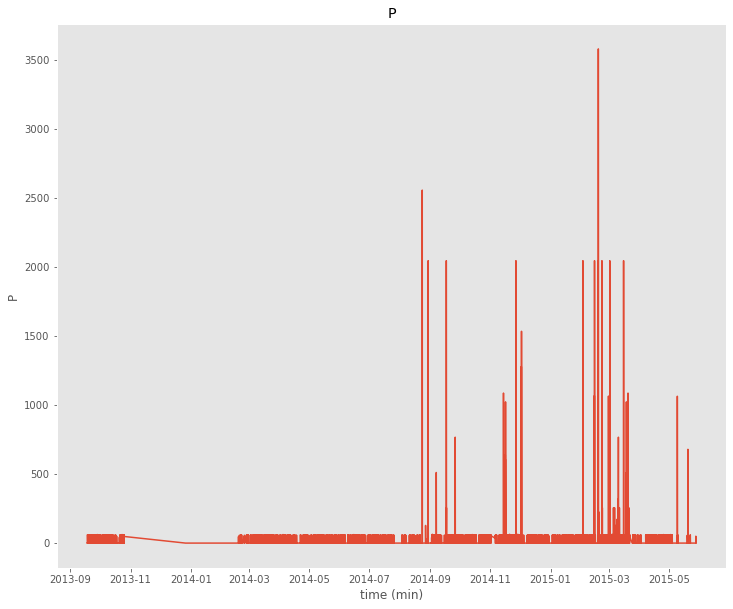

In [5]:
elec = dataset.buildings[2].elec
appl = elec['television']

appl.available_columns()
df = next(appl.load(physical_quantity='power'))
 #df = df.power.active #for iawe
fig, ax = plt.subplots()
ax.plot(df.fillna(0))

 
ax.set(xlabel='time (min)', ylabel='P', title='P')
ax.grid()

#df.power.active[1900:1950]

In [4]:
ts_size = 600
ts = df.power.values.transpose()
if ts.shape[1] <= ts_size:
    ts_pad = np.pad(ts, [(0,0),(0, ts_size-ts.shape[1])], 'constant')
else:
    #handle edge case
    ts_pad = ts[:,:ts_size]
    
rp = RecurrencePlot(threshold='distance', percentage=2)
X_rp = rp.fit_transform(ts_pad)

# Show the results for the first time series
plt.figure(figsize=(7, 7))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title('Recurrence Plot', fontsize=16)
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

In [4]:
def printLog(*args, **kwargs):
    #print(*args, **kwargs)
    with open('D:/jjenko/nilm data/GAF_DS/output2.txt','a') as file:
        print(*args, **kwargs, file=file)

def create_file(dataset_name,step_in_mins,dataset_size,img_size,n_of_multi_dim_imgs,appliances,**kwargs):
    
    #cell is responsible for storing and handling with hdf5 data
    #if file does not exist create new one (M-n of months A-n of appliances)
    #file_name = "UKDALE_GAF_1h_12M10A300N"
    ts_save = kwargs.get('ts_save', None)
    trs_type = kwargs.get('trs_type', None)
    overlap_images = kwargs.get('overlap_images', None)
    overlap_images_by_n = kwargs.get('overlap_images_by_n', None)
    trs_type_gaf = kwargs.get('trs_type_gaf', None)
    n_buildings = kwargs.get('n_buildings',None)
    multiple_buildings = kwargs.get('multiple_buildings', None)

    if overlap_images == True:
        overlap_images_str="Y"
    else:
        overlap_images_str="N"


    if trs_type == "GAF":
        trs_type = trs_type_gaf

    if ts_save == "Y":
        file_name =f"{dataset_name}""_"f"{trs_type}""_"f"{step_in_mins}""m_"f"{img_size}""S"f"{n_of_multi_dim_imgs-overlap_images_by_n}""X_"f"{ts_save}""-TS_"f"{len(appliances)}""A"f"{dataset_size}""N_"f"{multiple_buildings}""-B_"f"{overlap_images_str}""-O_Y-S"
    else:
        file_name =f"{dataset_name}""_"f"{trs_type}""_"f"{step_in_mins}""m_"f"{img_size}""S"f"{n_of_multi_dim_imgs-overlap_images_by_n}""X_"f"{len(appliances)}""A"f"{dataset_size}""N_"f"{multiple_buildings}""-B_"f"{overlap_images_str}""-O_Y-S"

    #check if file exists
    try:
        file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5","r")
        print("file exists!")
        file.close()

    except:
        print("creating new file! ...")
        file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "w")


        group = file.create_group("classes")
        
        file.close()

   

    return file_name

def create_hdf5_group(group_name): #groups are appliances such as fridge or toaster

    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    dataset = file.create_group(f"{group_name}")
    file.close()


def store_single_hdf5(data, file_id, group_name): 
    """
    Stores single image to HDF5
    """     
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    group = file[f"{group_name}"]
    
    try:
        group.create_dataset(f"{file_id}",np.shape(data),data = data)  
    except:
        del group[f"{file_id}"]
        group.create_dataset(f"{file_id}",np.shape(data),data = data)
        print("  replaced "f"{file_id}""!")
   
    file.close()

def store_many_hdf5(images,group_name,image_set_name,**kwargs):
    """
    Stores multiple images to HDF5
    **kwargs(force_del="yes" to replace existing db w/o prompt)
    """     
    #define some parameters
    num_images = len(images)
    force_del_flag = kwargs.get('force_del', None)# we need it, if "store many" is frequently called
    
    label_flag = kwargs.get('labels', None)# we need it, if "store many" is frequently called

    # read HDF5 file
    try:
        file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "a")
    except:
        print("file not found!")
    
    
    # open specified group
    try:
        group = file[f"{group_name}"]
    except:
        #if if does not exist create it
        group = file.create_group(f"{group_name}")
        
     
    #check if ds already exists, then prompt user
    for name in group:
        if str(name) == str(image_set_name):
            if force_del_flag == "yes":
                print("  removed "f"{name}""!")   
                del group[name]
            else:
                print("Dataset '"f"{name}" "' already exists in " f"{file_name}""/"f"{group_name}")
                
                ans = input("Do you want to replace existing dataset? (y,n) Press enter to contine")
                    
                if ans == "y":
                    print("  removed "f"{name}""!")   
                    del group[name]
                else:
                    print("  quiting! ") 
                    raise

    # Create a dataset in the group       
    print("storing... samples to store: "f"{num_images}")
    
    if label_flag == True:
        #save labels as integers. If sentence needed in case no labels are provided
        dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.H5T_STD_I8BE , data=images)
    else:
        dataset = group.create_dataset(f"{image_set_name}", np.shape(images), h5py.h5t.IEEE_F32LE , data=images)
    
    file.close()
    print("finshed. stored to " f"{file_name}""/"f"{group_name}""/"f"{image_set_name}")


def read_many_hdf5(group_name,image_set_name):
    """ 
    Reads image from HDF5.

    """
    images = []


    # Open the HDF5 file
    file = h5py.File("D:/jjenko/nilm data/GAF_DS/"f"{file_name}"".hdf5", "r+")

    images = np.array(file[f"{group_name}""/"f"{image_set_name}"])

    return images



In [ ]:
#(debug)graph first portion of the seleted range
# n = 18
# ukdale.set_window(start=date_range[n],end=date_range[n+1])
# elec = ukdale.buildings[1].elec
# fridge = elec['fridge']
# fridge.available_columns()
# df = next(fridge.load(physical_quantity='power'))
# print(len(df))
# fig, ax = plt.subplots()
# ax.plot(df)
# ax.set(xlabel='time (min)', ylabel='P', title='P')
# ax.grid()

In [ ]:
#next 3 cells generate GAFs on based on manual selecont of interval
#select time range and period
#was working for hourly data--
# step_in_hrs = 1
# date_range = pd.date_range("2013-1-10T0000", "2014-1-1T0000",freq=''+str(step_in_hrs)+'h')
#----------
#print(date_range)

In [32]:
dataset.metadata["meter_devices"]

{'smart_meter': {'model': 'Smart Meter',
  'model_url': 'http://www.landisgyr.com/webfoo/wp-content/uploads/2012/12/Landis+Gyr-E750-Brochure-English.pdf',
  'description': '1 Hz aggregate consumption data. Each measurement contains data  on current, voltage, and phase shift for each of the three phases  in the household.\n',
  'sample_period': 1,
  'max_sample_period': 1,
  'measurements': [{'physical_quantity': 'power',
    'type': 'active',
    'upper_limit': 100000,
    'lower_limit': 0},
   {'physical_quantity': 'current', 'upper_limit': 20, 'lower_limit': 0},
   {'physical_quantity': 'voltage', 'upper_limit': 400, 'lower_limit': 0},
   {'physical_quantity': 'phase_angle', 'upper_limit': 360, 'lower_limit': 0},
   {'physical_quantity': 'power',
    'type': 'reactive',
    'upper_limit': 100000,
    'lower_limit': -100000}],
  'wireless': False},
 'plug': {'model': 'Plug',
  'description': '1 Hz plug-level data measured from selected appliances.\n',
  'sample_period': 1,
  'max_samp

In [8]:
#--PARAMTERS--#

#-step
step_in_mins = 13
#-image
max_dataset_size =  100 #max number of images per appliance per buidling 
img_size = 100 # means img_size x img_size (igored when using RECC)
n_of_multi_dim_imgs = 10 #change to 0 for normal images (read overlap)

#-samples
sample_period = 1 # cm be obtained from dataset.metadata["sample_period"] but it is inconsistent
percentage_of_missing_data_allowed = 0.73 # is necessary since sampling rate is inconsistent or samples are missing 

#-timeseries
ts_save = "N" # "Y" - save soruce time-series data to output GAF dataset. "N" - do not save ts data
ts_size = round(step_in_mins*60/sample_period) # calculate estimate size of ts

#-trans type
trs_type = "GAF" #GAF or RECU - Gramian Angural Field or Recurrance plot

 #-if trans type GAF 
trs_type_gaf = "GASF" # GASF or GADF

#-overlap images (read comments bellow!)
overlap_images = False #True or false 
overlap_images_by_n = 0 #how many images should overlap  **will make n_of_multi_dim_imags shorter by overlap_image_by_n!!!***

if overlap_images==False : overlap_images_by_n = 0; # safety! 


#-buildings
n_buildings = len(dataset.buildings)
multiple_buildings = "N" # multiple buildings Y on N


#-classes and approximate date range
if dataset.metadata["name"] == "REDD":
    #appliances for redd
    #manualy_selected_appliances = ["microwave","washer dryer", "dish washer","electric stove","electric oven","fridge","electric space heater","light"]
    manualy_selected_appliances = ["light","fridge","microwave"]
    date_range = pd.date_range("2010-1-10T0000", "2012-5-20T0000",freq=f'{step_in_mins}''T')

elif dataset.metadata["name"] == "iAWE":
    #applicances for iawe 
    manualy_selected_appliances = ["fridge","television","clothes iron","washing machine","computer"]
    date_range = pd.date_range("2013-1-18T1800", "2013-12-18T1900",freq=f'{step_in_mins}''T')

elif dataset.metadata["name"] == "UK-DALE":
    #appliances for ukdale
    manualy_selected_appliances = ["computer monitor", "laptop computer", "television", "washer dryer", "microwave","boiler","toaster","kettle","fridge"]
    date_range = pd.date_range("2013-1-10T0000", "2014-2-20T0000",freq=f'{step_in_mins}''T') #max 2014-9

elif dataset.metadata["name"] == "REFIT":
    #appliances for ukdale
    manualy_selected_appliances = ['washing machine','television','microwave','fridge freezer','dish washer','kettle','fridge','computer',"toaster"]
    #manualy_selected_appliances = ['kettle','microwave','television','washing machine','dish washer','tumble dryer','freezer','fridge freezer','toaster']
    date_range = pd.date_range("2013-10-10T0000", "2015-8-20T0000",freq=f'{step_in_mins}''T') #max 2014-9
    
elif dataset.metadata["name"] == "ECO":
    #appliances for ukdale
    manualy_selected_appliances = ["freezer", "fridge", "kettle", "coffee maker", "computer","laptop computer","microwave","lamp"]
    date_range = pd.date_range("2012-06-10T0000", "2013-03-20T0000",freq=f'{step_in_mins}''T') #max 2014-9

else:
    print("error: dataset used is not compatible with this parser!")
    raise  


#main parameters - these are arrays that will hold all of the appended data
#save parameters
 
printLog("dataset name: ",dataset.metadata["name"],", date : ",datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')," \n"

"using data from ",date_range[0]," to ", date_range[-1]," \n"



" transtype: "f"{trs_type}","\n"
" gaf trans type: "f"{trs_type_gaf}","\n"

" windows size in mins: "f"{step_in_mins}","\n"
" image size in pixels: "f"{img_size}","\n"

" number if images that are stacked together and in series(true series!): "f"{n_of_multi_dim_imgs}","\n"

" overlap multidim images: "f"{overlap_images}","\n"
" overlap multidim images by number of: "f"{overlap_images_by_n}","\n"
" true number of images stacked together due to overlaping is: "f"{n_of_multi_dim_imgs-overlap_images_by_n}","\n"

" save source timeseries: "f"{ts_save}","\n"

" number of appliances: "f"{len(manualy_selected_appliances)}","\n"
" number of buildings: "f"{n_buildings}","\n"

" max number of images per appliance per building: "f"{max_dataset_size}","\n"
" max number of images per appliance: "f"{max_dataset_size*n_buildings}","\n"
" max number of images (real number is always smaller): "f"{max_dataset_size*n_buildings*len(manualy_selected_appliances)}","\n"

" include multiple buildings (Y for Yes N for No): "f"{multiple_buildings}","\n"
)
#handle case where:
if trs_type == "RECU":
    img_size = ts_size # recc tf output is same size as input ts

if n_of_multi_dim_imgs != 0:
    #use 4 dims
    gasf_stack_main = np.empty([0,n_of_multi_dim_imgs,img_size,img_size])
    ts_stack_main = np.empty([0,n_of_multi_dim_imgs,ts_size])

    if overlap_images == True:
        #multidim size will be a bit smaller, due to overlap
        gasf_stack_main = np.empty([0,n_of_multi_dim_imgs-overlap_images_by_n,img_size,img_size])
        ts_stack_main = np.empty([0,n_of_multi_dim_imgs-overlap_images_by_n,ts_size])

else:
    #use 3 dims
    gasf_stack_main = np.empty([0,img_size,img_size])
    ts_stack_main = np.empty([0,ts_size])

label_stack = np.empty(0)
label_building = np.empty(0)

appliance_weights = np.empty(0)
healthy_appliances = []
healthy_appliance_counter = 0 

last_interval = 0
breaker_stack_full = False

max_dataset_size_tmp  = 0
max_dataset_size_tmp_last = 0

#the idea is to loop through all of the applianes and collect at least N of "max_dataset_size" images for each one
for appliance in manualy_selected_appliances:
    printLog("\n")
    printLog("starting "f"{appliance} ("+str(manualy_selected_appliances.index(appliance)+1)+"/"+str(len(manualy_selected_appliances))+"):")
    print("\n")
    print("starting "f"{appliance} ("+str(manualy_selected_appliances.index(appliance)+1)+"/"+str(len(manualy_selected_appliances))+"):")
    
    
    #define some of the paramteres mainly for creating stack of images
    N_of_dates = len(date_range)-2

    #check if user selected mutli dim images
    if n_of_multi_dim_imgs != 0:
        gasf_stack_tmp = np.empty([0,img_size,img_size])
        ts_stack_tmp = np.empty([0,ts_size])

        gasf_stack = np.empty([0,n_of_multi_dim_imgs,img_size,img_size])
        ts_stack = np.empty([0,n_of_multi_dim_imgs,ts_size])

        if overlap_images == True:
            #multidim size will be a bit smaller
            gasf_stack = np.empty([0,n_of_multi_dim_imgs-overlap_images_by_n,img_size,img_size])
            ts_stack = np.empty([0,n_of_multi_dim_imgs-overlap_images_by_n,ts_size])
        


    else:
        gasf_stack = np.empty([0,img_size,img_size])
        ts_stack = np.empty([0,ts_size])
    
    
    for building in dataset.buildings:
        
        
        # use only 1st building if muliple_buildings == "NO"
        if multiple_buildings == "N":
                if building > 1:
                    print("skipping building "f"{building}"" due to parameter muliple_buildings ")
                    continue

        for meter in dataset.buildings[building].elec.submeters().meters:
            
            # get name and instance of an appliance from metadata
            appliance_metadata = meter.appliances[0].metadata
            label = appliance_metadata.get("type")
            instance = appliance_metadata.get("instance")
            
            #select only appliance that is selected in the first loop
            if label != appliance : continue
            

            #max_dataset_size_tmp = max_dataset_size + gasf_stack.shape[0]
            last_dataset_size = gasf_stack.shape[0]


            for interval in range(N_of_dates):
                
                print("\r",
                    " data procesed: ",round(100*interval/(N_of_dates-1),2),"% ",
                    " finished: ",round(100*((gasf_stack.shape[0]-last_dataset_size)/max_dataset_size),2),"% | ",
                    " building ",building," | ",
                    end="")
    
                #try to read from dataset
                try:
                    dataset.set_window(start=date_range[interval],end=date_range[interval+1])
                    df = next(meter.load(physical_quantity='power'))
        
                except:
                    #uncomment fo debug
                    #print("problem, no data for "+appliance+"!")
                    continue
                
                df = next(meter.load(physical_quantity='power'))

                #do some metric calcs in order to determine if selected window needs to be dropped
                metric = (60*step_in_mins)/sample_period # will adjust automaticly
                if len(df) < percentage_of_missing_data_allowed*metric:# -> manualy select %
                    #uncomment for debug
                    # if len(df) != 0:
                    #     print("skipped: "+str(date_range[interval])+" had only "+str(len(df))+" out of "+str(metric)+" points ("+str(int(100*(len(df))/metric))+"%)")
                    continue 
                
                #check if all values in an array are equal to 0

                
                #read power data and write it to timeseries
                ts = df.power.active.values.transpose()
                
                All_zero = np.all(ts==0)  
                All_ones = np.all(ts==1)  
                All_equal = np.all(ts==ts[0])
                All_lessthan = np.all(ts < 30 ) #if consumed power is lower than 30 watts

                if All_zero == True or All_ones == True or All_equal == True  or All_lessthan == True :
                    #print("skipped due all zero or all one: timeseries:")
                    #if all values are 0 then skip
                    continue

            
                #check if dataset size is larger than specified
                if gasf_stack.shape[0] >= (last_dataset_size + max_dataset_size):
                    print("max DS size reached size of "f"{max_dataset_size}"", skipping!")   
                    printLog("max DS size reached size of "f"{max_dataset_size}"", skipping! dataset size: ", gasf_stack.shape[0])
                    breaker_stack_full = True
                    break

                #do some timeseries reshaping and padding 
                #add new axis to for padding and gafs
                ts = ts[np.newaxis,:]
                if ts.shape[1] <= ts_size:
                    ts_pad = np.pad(ts, [(0,0),(0, ts_size-ts.shape[1])], 'constant')
                else:
                    #handle edge case
                    ts_pad = ts[:,:ts_size]

                #recurrence transform
                if trs_type == "RECU":
                    rp = RecurrencePlot(threshold=None)
                    X_gasf = rp.fit_transform(ts_pad)

                #gaf transform
                if trs_type == "GAF":
                    
                   
                    # Transform the time series into Gramian Angular Fields
                    if trs_type_gaf == "GASF":
                        gasf = GramianAngularField(image_size=img_size, method='summation')
                        X_gasf = gasf.fit_transform(ts_pad)

                    if trs_type_gaf == "GADF":
                        gadf = GramianAngularField(image_size=img_size, method='difference')
                        X_gasf = gadf.fit_transform(ts_pad)
                
                #part where we save converted images
                if len(gasf_stack.shape) == 4:

                    #append as multi dimensonal images 
                    if gasf_stack_tmp.shape[0] < n_of_multi_dim_imgs:
                        
                        #images in multi dim array must be in strict series order
                        delta_interval = interval - last_interval 
                        last_interval = interval
                        
                        if delta_interval == 1:

                        
                            #append, images are strictly in series
                            gasf_stack_tmp = np.append(gasf_stack_tmp,X_gasf,axis=0)
                            ts_stack_tmp = np.append(ts_stack_tmp,ts_pad,axis=0)
                            #print("series di,", delta_interval)

                        else:
                            #reset stack to 0
                            ts_stack_tmp = np.empty([0,ts_size])
                            gasf_stack_tmp = np.empty([0,img_size,img_size])
                            #print("skip di,", delta_interval)

                    

                    else:
                        #full 
                        if overlap_images == True:
                            #overlap
                            gasf_stack_tmp_new_axis = gasf_stack_tmp[np.newaxis,0:len(gasf_stack_tmp)-overlap_images_by_n] #add new axis for compatability 
                            gasf_stack = np.append(gasf_stack,gasf_stack_tmp_new_axis,axis=0)
                            
                            ts_stack_tmp_new_axis = ts_stack_tmp[np.newaxis,0:len(gasf_stack_tmp)-overlap_images_by_n] #add new axis for compatability
                            ts_stack = np.append(ts_stack,ts_stack_tmp_new_axis,axis=0)

                            label_stack = np.append(label_stack,int(f"{manualy_selected_appliances.index(appliance)}"))
                            label_building = np.append(label_building,building)
                            
                            #save some values that will overlap
                            gasf_stack_tmp = gasf_stack_tmp[len(gasf_stack_tmp)-overlap_images_by_n:]
                            ts_stack_tmp_tmp = ts_stack_tmp[len(ts_stack_tmp)-overlap_images_by_n:]
                            
                        
                        else:
                            #do not overlap
                            gasf_stack_tmp = gasf_stack_tmp[np.newaxis, ...] #add new axis for compatability
                            gasf_stack = np.append(gasf_stack,gasf_stack_tmp,axis=0)
                            
                            ts_stack_tmp = ts_stack_tmp[np.newaxis, ...] #add new axis for compatability
                            ts_stack = np.append(ts_stack,ts_stack_tmp,axis=0)

                            label_stack = np.append(label_stack,int(f"{manualy_selected_appliances.index(appliance)}"))
                            label_building = np.append(label_building,building)
                            
                            #reset stack to 0
                            ts_stack_tmp = np.empty([0,ts_size])
                            gasf_stack_tmp = np.empty([0,img_size,img_size])

                else:
                    #append as ordinary images
                    gasf_stack = np.append(gasf_stack,X_gasf,axis=0)
                    label_stack = np.append(label_stack,healthy_appliance_counter)
                    label_building = np.append(label_building,building)
                    ts_stack = np.append(ts_stack,ts_pad,axis=0)
                
                if interval == N_of_dates-1:
                    printLog("last interval, dataset size: ", gasf_stack.shape[0])

            # #break out of two for loops (interval and meters )
            # if breaker_stack_full:
            #     print("breaker")
            #     breaker_stack_full = False
            #     break

        print("finished building N",building,"status: data procesed: ",round(100*interval/(N_of_dates-1),2),"% ")
        printLog("finished building N",building,"status: data procesed: ",round(100*interval/(N_of_dates-1),2),"% ")

       
    

        

    printLog("")
    printLog("number of images (per appliance) stacked: "f"{gasf_stack.shape[0]}"" out of all possible " f"{N_of_dates}" " ("f"{int(100*gasf_stack.shape[0]/(N_of_dates*len(dataset.buildings)))}""%)")
    print("")
    print("number of images (per appliance) stacked: "f"{gasf_stack.shape[0]}"" out of all possible " f"{N_of_dates}" " ("f"{int(100*gasf_stack.shape[0]/(N_of_dates*len(dataset.buildings)))}""%)")

    gasf_stack_main = np.append(gasf_stack_main,gasf_stack,axis=0)
    ts_stack_main = np.append(ts_stack_main,ts_stack,axis=0)

    if gasf_stack.shape[0] != 0:
        appliance_weights = np.append(appliance_weights,round(gasf_stack.shape[0]/(max_dataset_size*len(dataset.buildings)),2))
        healthy_appliances.append(appliance)
        healthy_appliance_counter += 1 # this int is used for labels

    else:
        printLog("no usefull data for "f"{appliance}"" found, skipping")

    printLog("finished "f"{appliance}")
    print("finished "f"{appliance}")
    
    print("\n")
    printLog("\n")

# finished, store the images    

file_name = create_file(dataset.metadata["name"],step_in_mins,gasf_stack_main.shape[0],img_size,n_of_multi_dim_imgs,healthy_appliances,ts_save=ts_save,trs_type=trs_type,trs_type_gaf=trs_type_gaf,n_buildings=n_buildings,
multiple_buildings=multiple_buildings,overlap_images=overlap_images,overlap_images_by_n=overlap_images_by_n)

gasf_stack_main = gasf_stack_main[...,np.newaxis]
store_many_hdf5(gasf_stack_main,"data","gasf",force_del="yes")
store_many_hdf5(label_stack,"labels","gaf",force_del="yes",label=True)
store_many_hdf5(label_building,"labels","building",force_del="yes",label=True)
if ts_save == "Y":
    store_many_hdf5(ts_stack_main,"data","ts",force_del="yes")


asciiList = [n.encode("ascii", "ignore") for n in healthy_appliances]
store_single_hdf5(asciiList,"appliances","classes")
printLog("appliances stored: ", healthy_appliances)
print("appliances stored: ", healthy_appliances)
store_single_hdf5(appliance_weights,"weights", "classes")
printLog("weights stored: ", appliance_weights)
print("weights stored: ", appliance_weights)



starting freezer (1/8):
  data procesed:  0.37 %   finished:  100.0 % |   building  1  | max DS size reached size of 100, skipping!
finished building N 1 status: data procesed:  0.37 % 
skipping building 2 due to parameter muliple_buildings 
skipping building 3 due to parameter muliple_buildings 
skipping building 4 due to parameter muliple_buildings 
skipping building 5 due to parameter muliple_buildings 
skipping building 6 due to parameter muliple_buildings 

number of images (per appliance) stacked: 100 out of all possible 31346 (0%)
finished freezer




starting fridge (2/8):
  data procesed:  0.7 %   finished:  100.0 % |   building  1  | max DS size reached size of 100, skipping!
finished building N 1 status: data procesed:  0.7 % 
skipping building 2 due to parameter muliple_buildings 
skipping building 3 due to parameter muliple_buildings 
skipping building 4 due to parameter muliple_buildings 
skipping building 5 due to parameter muliple_buildings 
skipping building 6 due to